In [1]:
import numpy as np
from PIL import Image

def preprocess(image):
    # Resize
    ratio = 800.0 / min(image.size[0], image.size[1])
    image = image.resize((int(ratio * image.size[0]), int(ratio * image.size[1])), Image.BILINEAR)

    # Convert to BGR
    image = np.array(image)[:, :, [2, 1, 0]].astype('float32')

    # HWC -> CHW
    image = np.transpose(image, [2, 0, 1])

    # Normalize
    mean_vec = np.array([102.9801, 115.9465, 122.7717])
    for i in range(image.shape[0]):
        image[i, :, :] = image[i, :, :] - mean_vec[i]

    # Pad to be divisible of 32
    import math
    padded_h = int(math.ceil(image.shape[1] / 32) * 32)
    padded_w = int(math.ceil(image.shape[2] / 32) * 32)

    padded_image = np.zeros((3, padded_h, padded_w), dtype=np.float32)
    padded_image[:, :image.shape[1], :image.shape[2]] = image
    image = padded_image

    return image

# img = Image.open('dependencies/demo.jpg')
img = Image.open('images/cutlerry.jpg')
img_data = preprocess(img)


In [2]:
import sys

model_dir ="model/"
model=model_dir+"FasterRCNN-10.onnx"

path=sys.argv[1]

In [3]:
!pip install onnxruntime

In [4]:
import onnxruntime

session = onnxruntime.InferenceSession(model, None)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

results = session.get_outputs()[0]
labels = session.get_outputs()[1]
scores = session.get_outputs()[2]

print(results)
print(labels)
print(scores)

NodeArg(name='6379', type='tensor(float)', shape=['nbox', 4])
NodeArg(name='6381', type='tensor(int64)', shape=['nbox'])
NodeArg(name='6383', type='tensor(float)', shape=['nbox'])


In [5]:
result = session.run([results.name, labels.name, scores.name], {input_name: img_data})


boxes = result[0]
labels = result[1]
scores = result[2]

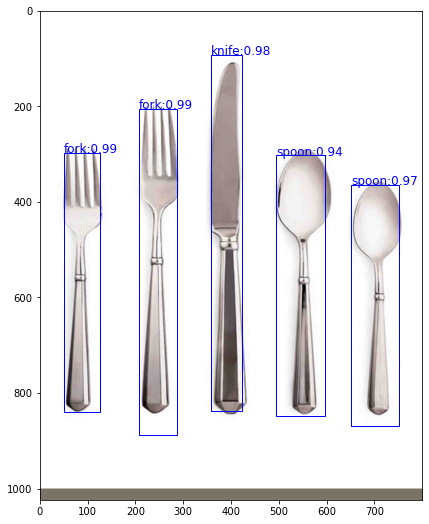

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

classes = [line.rstrip('\n') for line in open('classes/coco_classes.txt')]

def display_objdetect_image(image, boxes, labels, scores, score_threshold=0.7):
    # Resize boxes
    ratio = 800.0 / min(image.shape[0], image.shape[1])

    _, ax = plt.subplots(1, figsize=(12,9))
    
    
    mean_vec = np.array([102.9801, 115.9465, 122.7717])
    new_img = np.array(image, copy=True)  
    for i in range(image.shape[0]):
        new_img[i, :, :] = image[i, :, :] + mean_vec[i]
    
    new_img = np.transpose(new_img, [1, 2, 0])
    new_img = np.array(new_img)[:, :, [2, 1, 0]].astype('float32')
    new_img = np.array(new_img)
    new_img += -new_img.min();
    new_img /= new_img.max()
    
    ax.imshow(new_img)

    # Showing boxes with score > 0.7
    for box, label, score in zip(boxes, labels, scores):
        if score > score_threshold:
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='b', facecolor='none')
            ax.annotate(classes[label] + ':' + str(np.round(score, 2)), (box[0], box[1]), color='b', fontsize=12)
            ax.add_patch(rect)
    plt.show()

display_objdetect_image(img_data, boxes, labels, scores)